In [35]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator

from scipy.optimize import leastsq

import analysis_functions as af
import diagonalization_functions as df

import time
import os
import importlib

In [36]:
folder_load = 'data_240325_ng0p25'
amp = np.load(os.path.join(folder_load, 'amplitude_data.npy'))
pha = np.load(os.path.join(folder_load, 'phase_data.npy'))
dc = np.load(os.path.join(folder_load, 'dc_coord.npy'))
dc = (dc-5.625)/(5.65+3.65)*np.pi
freq = np.load(os.path.join(folder_load, 'spec_coord.npy'))
xdata, ydata = np.load(os.path.join(folder_load, 'manual_points.npy'))
xdata = (xdata-5.625)/(5.65+3.65)*np.pi
ydata /= 1e9
_, phiexts, lvls, _ = np.load('EC2p56_EJ2p90_EL0p41_ECS0p10_asym5_CuPy/vs_phiext_ng_0p25.npy', allow_pickle=True)
lvls = lvls.real

removed lines:  [4, 10, 12, 55, 57, 58, 60, 61, 62, 63, 64]


(1.99975, 4.499750000000001)

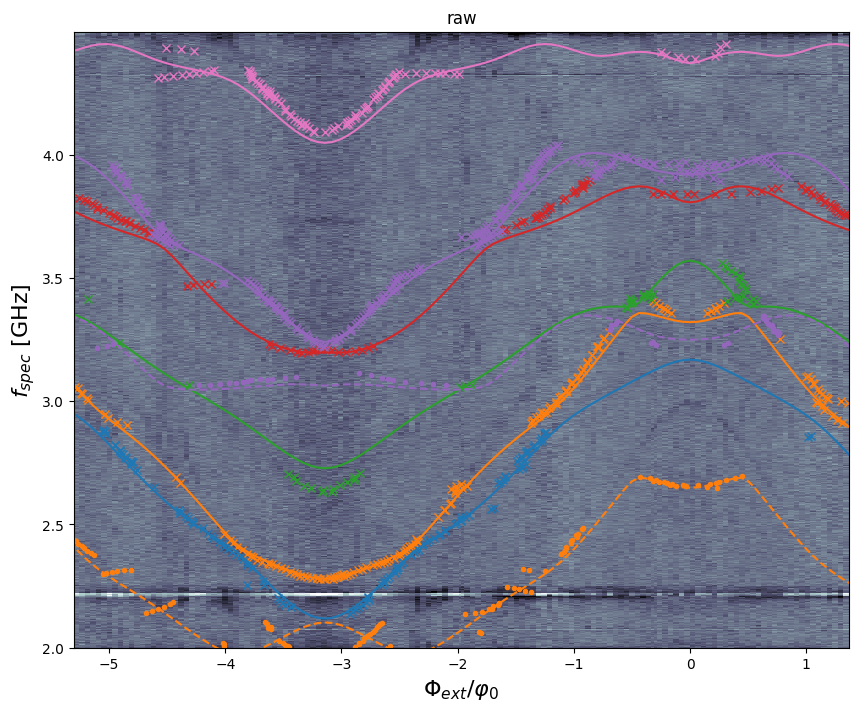

In [5]:
importlib.reload(af)
importlib.reload(df)

from_states = [0, 1]
Nlvl = lvls.shape[1]
simu_unfold = af.unfold_simu(xdata, phiexts, lvls, from_states)

banned = [58, 60, 61, 62]
data_assigned, offset_opt, cost = af.assign_data2(xdata, ydata, simu_unfold, banned)
simu_unfold['y'] -= offset_opt
# af.cleaner_data(data_assigned, 30)
simu_assigned = af.assign_simu(simu_unfold, data_assigned)
af.assign_style(simu_assigned, data_assigned, Nlvl)


fig, ax = plt.subplots(figsize=(10,8))
vmin = np.quantile(amp, 0.0001)
vmax = np.quantile(amp, 0.9999)
ax.pcolormesh(dc, freq/1e9, amp.T, shading='nearest', vmin=vmin, vmax=vmax, cmap='bone')
ylims = ax.get_ylim()
xlims = ax.get_xlim()
ax.set_title('raw')

Nass = data_assigned['x'].size
for ii in range(Nass):
    x, y, c, m = data_assigned['x'][ii], data_assigned['y'][ii], data_assigned['colors'][ii], data_assigned['markers'][ii]
    ax.plot(x, y, c='C%i'%c, marker=m)
    
Nass = simu_assigned['line_colors'].size
for ii in range(Nass):
    ax.plot(simu_assigned['x'], simu_assigned['y'][ii], c='C%i'%(simu_assigned['line_colors'][ii]), ls=simu_assigned['linestyles'][ii])

ax.plot(xdata, ydata, '.', zorder=0, c='k')
    
ax.set_xlabel(r'$\Phi_{ext}/\varphi_0$', fontsize=16)
ax.set_ylabel(r'$f_{spec}$ [GHz]', fontsize=16)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

In [41]:
simu_unfold['x'].min()

-5.340707511102648

In [42]:
data_assigned['x'].min()

-5.2977915

# Checking optimal diagonalization setup

At the guess value we run different kinds of simulation:
- sparse matrix
- dense matrix
- dense matrix batched

And we optimize:
- the truncation
- the n_cutoff (if sparse)

We look for the fastest setup, tolerating less than 1e-3 (1MHz) maximum error on the whole band.

In [4]:
importlib.reload(af)
importlib.reload(df)

check_trunc = True
mode = 'dense'
is_batched = False

bare_params = [2.56, 2.90, 0.41, 0.1]   # EC, EJ, EL, ECshunt

ng = 0.25
phiexts = cp.linspace(-cp.pi, 0, 3)

dim_n = 6   # charge basis \pm dim_n, actual dimension is 2*dim_n+1
dim_phisigma = 12   # harmonic oscillator basis
dim_phidelta = 12   # harmonic oscillator basis
dim = [dim_n, dim_phisigma, dim_phidelta]
DIM, fock, FOCK = 2*dim[0]+1, dim[1], dim[2]
Hsize = DIM*fock*FOCK

EC, EJ, EL, ECshunt = bare_params
y = ECshunt/EC
dJ = 0.05*EJ
dC = -0.05*EJ   # DL 1st order in dJ/Ej
dL = 0

params = [EC, EJ, EL, y, dC, dJ, dL]

n_cutoff = 20
lvls = np.zeros((phiexts.size, n_cutoff))
err = np.zeros((phiexts.size, n_cutoff))
states = np.zeros((phiexts.size, Hsize, n_cutoff), dtype='complex')

if is_batched is True and mode == 'dense':
    H = cp.zeros((phiexts.size, Hsize, Hsize), dtype='complex')
    for jj, phiext in enumerate(phiexts):
        H[jj] = df.Hamiltonian_phi(df._Hamiltonian(dim, ng, params, mode=mode), phiext)
    t0 = time.time()
    lvls = df.first_n_vals_batched(H, n_cutoff).get()
    print('%.3fs' % (time.time() - t0))
    if check_trunc is True:
        dim_check = [dim_n+1, dim_phisigma+1, dim_phidelta+1]
        Hsize_check = (2*dim_check[0]+1) * dim_check[1] * dim_check[2]
        H = cp.zeros((phiexts.size, Hsize_check, Hsize_check), dtype='complex')
        for jj, phiext in enumerate(phiexts):
            H[jj] = df.Hamiltonian_phi(df._Hamiltonian(dim_check, ng, params, mode=mode), phiext)
        err = lvls - df.first_n_vals_batched(H, n_cutoff).get()

else:
    for jj, phiext in enumerate(phiexts):
        t0 = time.time()
        H = df.Hamiltonian_phi(df._Hamiltonian(dim, ng, params, mode=mode), phiext)
        ev, evec = df.first_n_states(H, n_cutoff, dim, mode=mode)
        lvls[jj] = ev.get().real
        states[jj] = evec.get()
        print('%.3fs' % (time.time() - t0))
        if check_trunc is True:
            dim_check = [dim_n+1, dim_phisigma+1, dim_phidelta+1]
            H = df.Hamiltonian_phi(df._Hamiltonian(dim_check, ng, params, mode=mode), phiext)
            ev, evec = df.first_n_states(H, n_cutoff, dim_check, mode=mode)
            err[jj] = lvls[jj] - ev.get().real
    


1.450s
0.204s
0.205s


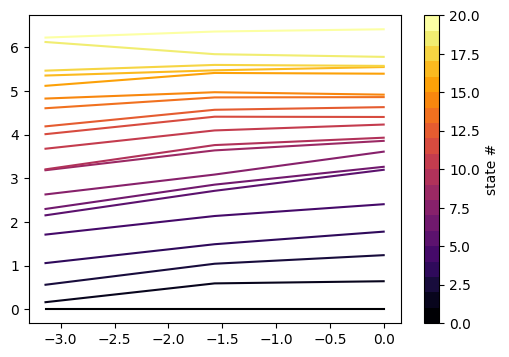

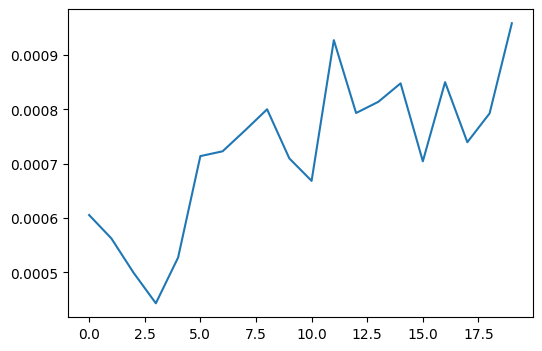

In [5]:
cmap = mpl.colormaps['inferno'].resampled(n_cutoff)

fig, ax = plt.subplots(figsize=(6,4))
for ii in range(n_cutoff):
    ax.plot(phiexts.get(), lvls.T[ii] - lvls.T[0], c=cmap(ii))
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, n_cutoff), cmap=cmap),
             ax=ax, orientation='vertical', label='state #')

if check_trunc is True:
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(np.arange(0, n_cutoff), np.max(np.abs(err), 0))

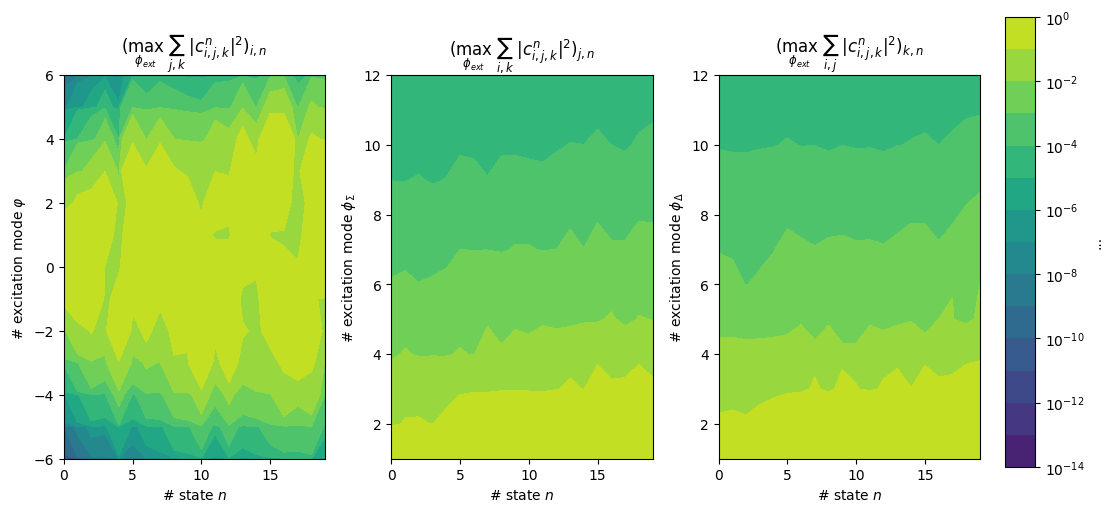

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(10,5), sharex=True)

weights = np.abs(states.reshape(phiexts.size, DIM, fock, FOCK, n_cutoff))**2
weights_c = weights.sum((2,3)).max(0)
weights_r = weights.sum((1,3)).max(0)
weights_f = weights.sum((1,2)).max(0)

levels = np.logspace(-14,0,15)
im = ax[0].contourf(
    np.arange(0, n_cutoff), 
    np.arange(0, DIM) - dim_n,
    weights_c,
    levels,
    norm=LogNorm(vmin=1e-15, vmax=10))
ax[0].set_xlabel(r'# state $n$')
ax[0].set_ylabel(r'# excitation mode $\varphi$')
ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))

ax[1].contourf(
    np.arange(0, n_cutoff),
    np.arange(0, fock)+1, 
    weights_r,
    levels,
    norm=LogNorm(vmin=1e-15, vmax=10))
ax[1].set_xlabel(r'# state $n$')
ax[1].set_ylabel(r'# excitation mode $\phi_\Sigma$')
ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))

ax[2].contourf(
    np.arange(0, n_cutoff),
    np.arange(0, FOCK)+1, 
    weights_f, 
    levels,
    norm=LogNorm(vmin=1e-15, vmax=10))
ax[2].set_xlabel(r'# state $n$')
ax[2].set_ylabel(r'# excitation mode $\phi_\Delta$')
ax[2].yaxis.set_major_locator(MaxNLocator(integer=True))

ax[0].set_title(r'$(\max_{\phi_{ext}} \; \sum_{j,k} \; |c_{i,j,k}^n|^2 )_{i,n}$')
ax[1].set_title(r'$(\max_{\phi_{ext}} \; \sum_{i,k} \; |c_{i,j,k}^n|^2 )_{j,n}$')
ax[2].set_title(r'$(\max_{\phi_{ext}} \; \sum_{i,j} \; |c_{i,j,k}^n|^2 )_{k,n}$')

fig.tight_layout()
cbar_ax = fig.add_axes([1.01, 0.1, 0.03, 0.9])
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='...')



In [103]:
importlib.reload(af)
importlib.reload(df)

simu_unfold = af.unfold_simu(data_assigned['x'], phiexts, lvls, from_states)
simu_assigned = af.assign_simu(simu_unfold, data_assigned)
ysimu, ydata = af.get_distance(data_assigned, simu_assigned)

In [98]:
dtype = [('x', 'f4'), ('y', 'f4')]
data = np.empty(3, dtype=dtype)
data['x'] = np.zeros(3)
data['y'] = np.nan
print(data['y'])

[nan nan nan]


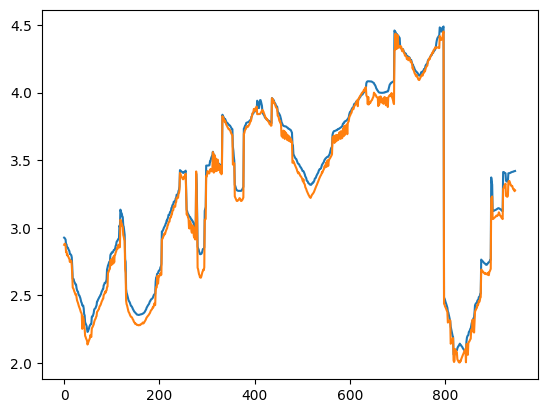

In [104]:
fig, ax = plt.subplots()
ax.plot(ysimu)
ax.plot(ydata)

In [111]:
data_assigned['found_lines']

array([ 5,  6,  7,  8,  9, 11, 56, 59], dtype=int32)

In [7]:
importlib.reload(af)
importlib.reload(df)

### set simulation specs
dim_n = 6
dim_phisigma = 12
dim_phidelta = 12
dim = [dim_n, dim_phisigma, dim_phidelta]
DIM, fock, FOCK = 2*dim[0]+1, dim[1], dim[2]
Hsize = DIM*fock*FOCK

### load data
folder_load = 'data_240325_ng0p25'
amp = np.load(os.path.join(folder_load, 'amplitude_data.npy'))
pha = np.load(os.path.join(folder_load, 'phase_data.npy'))
dc = np.load(os.path.join(folder_load, 'dc_coord.npy'))
dc = (dc-5.625)/(5.65+3.65)*np.pi
freq = np.load(os.path.join(folder_load, 'spec_coord.npy'))
xdata, ydata = np.load(os.path.join(folder_load, 'manual_points.npy'))
xdata = (xdata-5.625)/(5.65+3.65)*np.pi
ydata /= 1e9

### compute guess
bare_params = [2.56, 2.90, 0.41, 0.1, 0.05]   # EC, EJ, EL, ECshunt, asym
EC, EJ, EL, ECshunt, asym = bare_params
y = ECshunt/EC
dJ = asym*EJ
dC = -asym*EJ 
dL = 0
params = [EC, EJ, EL, y, dC, dJ, dL]
phiexts = np.linspace(-np.pi, 0, 51)
ng = 0.25
n_cutoff = 20
lvls = np.zeros((phiexts.size, n_cutoff))
for jj, phiext in enumerate(phiexts):
    H = df.Hamiltonian_phi(df._Hamiltonian(dim, ng, params, mode='dense'), df.gpu(phiext))
    ev, _ = df.first_n_states(H, n_cutoff, dim, mode='dense')
    lvls[jj] = ev.get().real

### assign data according to guess
from_states = [0, 1]
Nlvl = lvls.shape[1]
guess_unfold = af.unfold_simu(xdata, phiexts, lvls, from_states)
banned = [58, 60, 61, 62]
data_assigned, offset_opt, _ = af.assign_data2(xdata, ydata, guess_unfold, banned)


def residuals(p0, data_assigned, phiexts, ng, from_states):
    
    wplasma, EJoEC, EL, ECshunt, asym = p0
    EJ = wplasma * cp.sqrt(EJoEC / 8)
    EC = wplasma / cp.sqrt(EJoEC * 8)
    y = ECshunt/EC
    dJ = asym*EJ
    dC = -asym*EJ   # DL 1st order in dJ/Ej
    dL = 0
    params = [EC, EJ, EL, y, dC, dJ, dL]
    lvls = np.zeros((phiexts.size, n_cutoff))
    for jj, phiext in enumerate(phiexts):
        H = df.Hamiltonian_phi(df._Hamiltonian(dim, ng, params, mode='dense'), df.gpu(phiext))
        ev, _ = df.first_n_states(H, n_cutoff, dim, mode='dense')
        lvls[jj] = ev.get().real

    simu_unfold = af.unfold_simu(data_assigned['x'], phiexts, lvls, from_states)
    distance = af.get_distance(data_assigned, simu_unfold)
    
    return distance

t0 = time.time()
p0 = np.array([np.sqrt(8*EJ*EC), EJ/EC, EL, ECshunt, asym])   # wplasma, EJoEC, EL, ECshunt, asym
p0 = np.array([7.7, 1.135, 0.410 ,0.100, 0.036])
res = leastsq(residuals, 
              p0, 
              args=(data_assigned, phiexts, ng, from_states), 
              maxfev=1000, 
              ftol=1e-3, 
              full_output=1)
print('%is'%(time.time()-t0))
popt, pcov, infodict, _, _ = res
cost = np.sum(infodict['fvec'] ** 2) # sum of residuals for the solution
if pcov is not None: # the leastsq routine outputs None when singular cov
    if data_assigned['x'].size > p0.size:
        s_sq = cost / (data.size - p0.size) # scaling by the ddf
        pcov = pcov * s_sq

removed lines:  [4, 10, 30, 33, 34]
159s


NameError: name 'data' is not defined

In [18]:
print(p0)
print(popt)
print(infodict['nfev'])
print(cost)
print(np.round(np.sqrt(np.abs(pcov)/np.outer(popt.T, popt)), 2))

[7.7   1.135 0.41  0.1   0.036]
[7.97061736 1.13533433 0.41009404 0.10095154 0.03619437]
13
1.2857851456222955
[[0.01 0.   0.01 0.   0.01]
 [0.   0.   0.   0.   0.01]
 [0.01 0.   0.   0.   0.01]
 [0.   0.   0.   0.   0.01]
 [0.01 0.01 0.01 0.01 0.3 ]]


In [19]:
wplasma, EJoEC, EL, ECshunt, asym = popt
EJ = wplasma * cp.sqrt(EJoEC / 8)
EC = wplasma / cp.sqrt(EJoEC * 8)
y = ECshunt/EC
dJ = asym*EJ
dC = -asym*EJ   # DL 1st order in dJ/Ej
dL = 0
params = [EC, EJ, EL, y, dC, dJ, dL]
lvls = np.zeros((phiexts.size, n_cutoff))
for jj, phiext in enumerate(phiexts):
    H = df.Hamiltonian_phi(df._Hamiltonian(dim, ng, params, mode='dense'), df.gpu(phiext))
    ev, _ = df.first_n_states(H, n_cutoff, dim, mode='dense')
    lvls[jj] = ev.get().real

Nlvl = lvls.shape[1]
result_unfold = af.unfold_simu(data_assigned['x'], phiexts, lvls, from_states)
result_assigned = af.assign_simu(result_unfold, data_assigned)
af.assign_style(result_assigned, data_assigned, Nlvl)

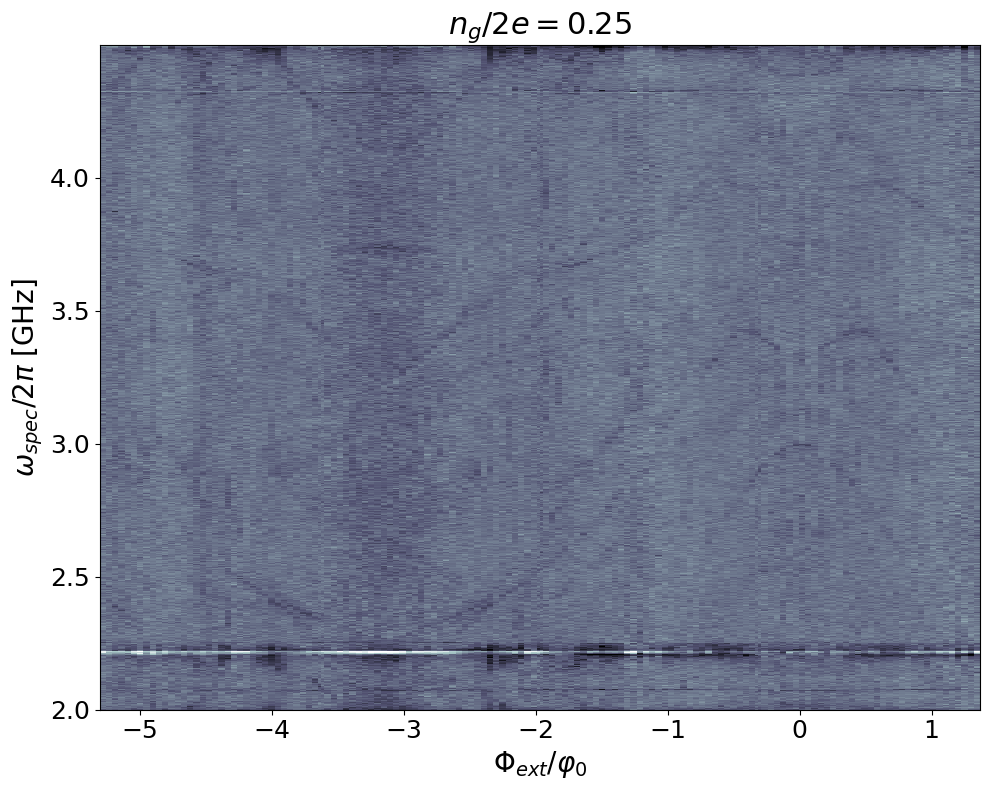

In [38]:
fig, ax = plt.subplots(figsize=(10,8))
vmin = np.quantile(amp, 0.0001)
vmax = np.quantile(amp, 0.9999)
ax.pcolormesh(dc, freq/1e9, amp.T, shading='nearest', vmin=vmin, vmax=vmax, cmap='bone')
ylims = ax.get_ylim()
xlims = ax.get_xlim()

ax.set_xlabel(r'$\Phi_{ext}/\varphi_0$', fontsize=20)
ax.set_ylabel(r'$\omega_{spec}/2\pi$ [GHz]', fontsize=20)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

ax.set_title(r'$n_g/2e = 0.25$', fontsize=22)

fig.tight_layout()
fig.savefig('fig.png')

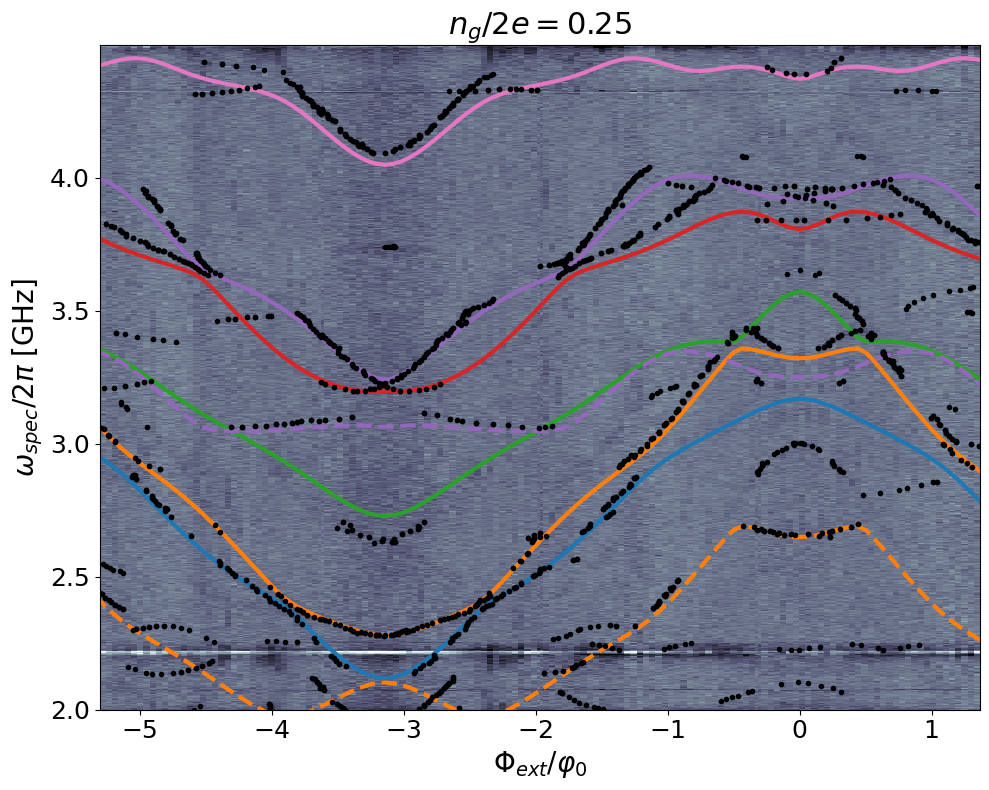

In [44]:
fig, ax = plt.subplots(figsize=(10,8))
vmin = np.quantile(amp, 0.0001)
vmax = np.quantile(amp, 0.9999)
ax.pcolormesh(dc, freq/1e9, amp.T, shading='nearest', vmin=vmin, vmax=vmax, cmap='bone')
ylims = ax.get_ylim()
xlims = ax.get_xlim()
# _ = ax.plot(simu_unfold['x'], simu_unfold['y'][:Nlvl].T)
# _ = ax.plot(simu_unfold['x'], simu_unfold['y'][Nlvl:].T, ls='--')

ax.plot(xdata, ydata, '.', zorder=1, c='k')
ax.plot(data_assigned['x'], data_assigned['y'], '.', zorder=2, c='k')


# Nass = data_assigned['x'].size
# for ii in range(Nass):
#     x, y, c, m = data_assigned['x'][ii], data_assigned['y'][ii], data_assigned['colors'][ii], data_assigned['markers'][ii]
#     ax.plot(x, y, c='C%i'%c, marker=m)
    
Nass = simu_assigned['line_colors'].size
for ii in range(Nass):
    ax.plot(simu_assigned['x'], simu_assigned['y'][ii], c='C%i'%(simu_assigned['line_colors'][ii]), ls=simu_assigned['linestyles'][ii], lw=3, zorder=1)

ax.set_xlabel(r'$\Phi_{ext}/\varphi_0$', fontsize=20)
ax.set_ylabel(r'$\omega_{spec}/2\pi$ [GHz]', fontsize=20)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

ax.set_title(r'$n_g/2e = 0.25$', fontsize=22)

fig.tight_layout()
fig.savefig('fig1.png')

In [50]:
# wplasma, EJoEC, EL, ECshunt, asym
popt = [7.9706, 1.13533433, 0.41009404, 0.10095154, 0.03619437] 
print('EJ=', popt[0]*np.sqrt(popt[1]/8))
print('ECJ=', popt[0]/np.sqrt(popt[1]*8))
print('wplasma=', np.sqrt(8*3*2.64))

EJ= 3.002672084759454
ECJ= 2.6447470189326996
wplasma= 7.95989949685296


In [32]:
folder_load = 'data_240402_ng0'
amp = np.load(os.path.join(folder_load, 'amplitude_data.npy'))
pha = np.load(os.path.join(folder_load, 'phase_data.npy'))
dc = np.load(os.path.join(folder_load, 'dc_coord.npy'))
dc = (dc-5.625)/(5.65+3.65)*np.pi
freq = np.load(os.path.join(folder_load, 'spec_coord.npy'))
#xdata, ydata = np.load(os.path.join(folder_load, 'manual_points.npy'))
#xdata = (xdata-5.625)/(5.65+3.65)*np.pi
#ydata /= 1e9
#_, phiexts, lvls, _ = np.load('EC2p56_EJ2p90_EL0p41_ECS0p10_asym5_CuPy/vs_phiext_ng_0p25.npy', allow_pickle=True)
#lvls = lvls.real

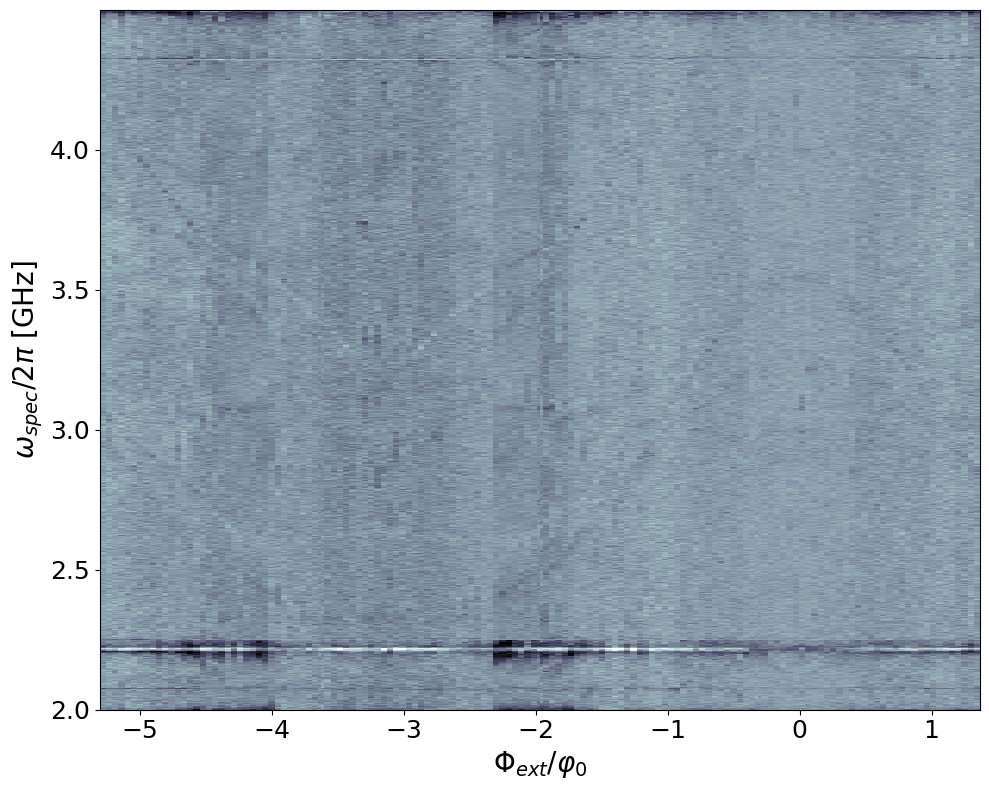

In [33]:
fig, ax = plt.subplots(figsize=(10,8))
vmin = np.quantile(amp, 0.0001)
vmax = np.quantile(amp, 0.9999)
ax.pcolormesh(dc, freq/1e9, amp.T, shading='nearest', vmin=vmin, vmax=vmax, cmap='bone')
ylims = ax.get_ylim()
xlims = ax.get_xlim()

ax.set_xlabel(r'$\Phi_{ext}/\varphi_0$', fontsize=20)
ax.set_ylabel(r'$\omega_{spec}/2\pi$ [GHz]', fontsize=20)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

fig.tight_layout()
fig.savefig('fig.png')